# Group Project
INSURED ANALYSIS

In [ ]:
# manage imports - probably need to clean this up later
import pandas as pd
import numpy as np
import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt
import datetime as dt
import requests
from lxml import html
import math
import re
import chardet
import shutil

In [ ]:
# delete the legacy files from the workbook
!rm /content/sample_data/*.*

In [ ]:
# attach the local google drive - select your UPenn google account
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# validate that you have access to the group project raw data archive folder
!ls -al "/content/drive/Shareddrives/CIS 5450 Group Project/Data"

total 2623202
-rw------- 1 root root 598085787 Apr 12 11:50  All_Policy_Data.csv
-rw------- 1 root root 417116605 Apr 17 18:40  All_Policy_Data_v2.csv
-rw------- 1 root root 656133164 Apr 12 11:51  Clean_Policy_Data.csv
-rw------- 1 root root    234987 Apr 12 11:51  Clean_Policy_Data_SAMPLE.csv
-rw------- 1 root root 499129205 Apr 12 11:51  GL_Policy_Data.csv
-rw------- 1 root root 360596483 Apr 17 18:40  GL_Policy_Data_v2.csv
drwx------ 2 root root      4096 Mar 29 13:39 'Raw Archive'
-rw------- 1 root root  98336072 Apr 12 11:51  WC_Policy_Data.csv
-rw------- 1 root root  56520690 Apr 17 18:40  WC_Policy_Data_v2.csv


In [ ]:
source = "/content/drive/Shareddrives/CIS 5450 Group Project/Data/WC_Policy_Data_v2.csv"
destination = "/content/sample_data/"
!cp "$source" "$destination"

In [ ]:
# Create initial data frame for policy data (takes ~10 seconds)
#!pwd
wc_policy_data_df = pd.read_csv("./sample_data/WC_Policy_Data_v2.csv", encoding="utf-8", dtype={'column_8': str, 'column_40': str},  low_memory=False)
print("Clean Policy Data - WC (Worker's Compensation)")
print("   Column Count: {}".format(wc_policy_data_df.shape[1]))
print("   Row Count:    {}".format(wc_policy_data_df.shape[0]))

Clean Policy Data - WC (Worker's Compensation)
   Column Count: 35
   Row Count:    114113


\
# Begin Analysis


We are first going to clean up the worker's comp data, and then further use this dataframe (called wc_data_df)for further analysis.

Data below if for **version 2**:

*   With Audit Count: **30264** (79.7%)
*   Without Audit Count: **7690** (20.3%)

Total number of rows: **37954**

In [ ]:
wc_data_df = wc_policy_data_df[["ProductMasterLineName", "ProductLineName", "StateCode", "CompanySalesAmt_USD", "EmployeesTotalCount", "SIC_2_Code", "CarrierMasterParentName", "TierName", "BilledPremium", "Limits", "Exposure", "HasAudit"]]

In [ ]:
audit_count = wc_data_df[wc_data_df["HasAudit"] == 1].count() / wc_data_df.count()
audit_count

ProductMasterLineName      0.572143
ProductLineName            0.572143
StateCode                  0.572143
CompanySalesAmt_USD        0.588101
EmployeesTotalCount        0.588101
SIC_2_Code                 0.572143
CarrierMasterParentName    0.572143
TierName                   0.572143
BilledPremium              0.572143
Limits                     0.778110
Exposure                   0.788689
HasAudit                   0.572143
dtype: float64

In [ ]:
no_audit_count = wc_data_df[wc_data_df["HasAudit"] == 0].count() / wc_data_df.count()
no_audit_count

ProductMasterLineName      0.427857
ProductLineName            0.427857
StateCode                  0.427857
CompanySalesAmt_USD        0.411899
EmployeesTotalCount        0.411899
SIC_2_Code                 0.427857
CarrierMasterParentName    0.427857
TierName                   0.427857
BilledPremium              0.427857
Limits                     0.221890
Exposure                   0.211311
HasAudit                   0.427857
dtype: float64

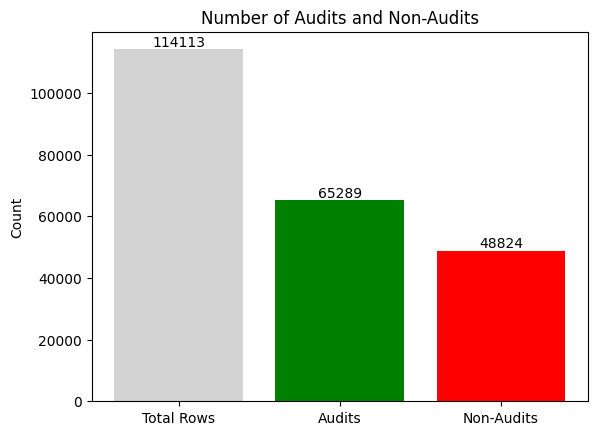

In [ ]:
# Showing visualization of raw data
audit_count = wc_data_df['HasAudit'].sum()
non_audit_count = len(wc_data_df) - audit_count
total_count = len(wc_data_df)

total_bar = plt.bar('Total Rows', total_count, color='lightgray', label='Total Rows')
audit_bar = plt.bar('Audits', audit_count, color='green', label='Rows with Audits')
non_audit_bar = plt.bar('Non-Audits', non_audit_count, color='red', label='Rows with Non-Audits')

plt.title('Number of Audits and Non-Audits')
plt.ylabel('Count')

def show_exact_number(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

show_exact_number(total_bar)
show_exact_number(audit_bar)
show_exact_number(non_audit_bar)

plt.show()

In [ ]:
wc_data_df = wc_data_df.dropna()
wc_data_df = wc_data_df[wc_data_df["SIC_2_Code"] != "UNKNOWN"] #removed unknowns --> no value provided
wc_data_df.head(10)

,ProductMasterLineName,ProductLineName,StateCode,CompanySalesAmt_USD,EmployeesTotalCount,SIC_2_Code,CarrierMasterParentName,TierName,BilledPremium,Limits,Exposure,HasAudit
772,C - WORKERS COMPENSATION-ALL OTHER,WORKERS COMPENSATION,FL,58970177.0,245.0,47,AMTRUST FINANCIAL GROUP,TIER 3,29500.0,3000000.0,34979400.0,1
919,C - WORKERS COMPENSATION-ALL OTHER,WORKERS COMPENSATION,WI,292129.0,9.0,58,STATE AUTOMOBILE MUTUAL INSURANCE COMPANY,TIER 3,468.0,9305000.0,0.0,1
930,C - WORKERS COMPENSATION-STANDARD,WORKERS COMPENSATION,NY,110000.0,2.0,78,INTACT INSURANCE GROUP,TIER 3,1325.0,3000000.0,246816.0,1
1043,C - WORKERS COMPENSATION-ALL OTHER,WORKERS COMPENSATION,ID,610675.0,16.0,17,AMTRUST FINANCIAL GROUP,TIER 3,7509.0,4105000.0,14136.0,0
1079,C - WORKERS COMPENSATION-STANDARD,WORKERS COMPENSATION,TN,11718848.0,82.0,73,TRAVELERS GROUP,TIER 1,107643.0,3000000.0,6236780.0,1
1080,C - WORKERS COMPENSATION-STANDARD,WORKERS COMPENSATION,TN,11718848.0,82.0,73,TRAVELERS GROUP,TIER 1,110927.0,3000000.0,6597585.0,1
1081,C - WORKERS COMPENSATION-STANDARD,WORKERS COMPENSATION,TN,11718848.0,82.0,73,TRAVELERS GROUP,TIER 1,85343.0,3000000.0,6427411.0,1
1283,C - WORKERS COMPENSATION-ALL OTHER,WORKERS COMPENSATION,CA,465086.0,1.0,57,AMTRUST FINANCIAL GROUP,TIER 3,9737.0,3000000.0,11711000.0,1
1349,C - WORKERS COMPENSATION-ALL OTHER,WORKERS COMPENSATION,NV,268435.0,5.0,17,AMTRUST FINANCIAL GROUP,TIER 3,612.0,1500000.0,1062900.0,1
1543,C - WORKERS COMPENSATION-STANDARD,WORKERS COMPENSATION,CA,92487.0,6.0,99,"PROSIGHT SPECIALTY INSURANCE HOLDINGS, INC.",TIER 3,4576.0,3000000.0,155000.0,1


In [ ]:
wc_data_df.dtypes

ProductMasterLineName       object
ProductLineName             object
StateCode                   object
CompanySalesAmt_USD        float64
EmployeesTotalCount        float64
SIC_2_Code                  object
CarrierMasterParentName     object
TierName                    object
BilledPremium              float64
Limits                     float64
Exposure                   float64
HasAudit                     int64
dtype: object

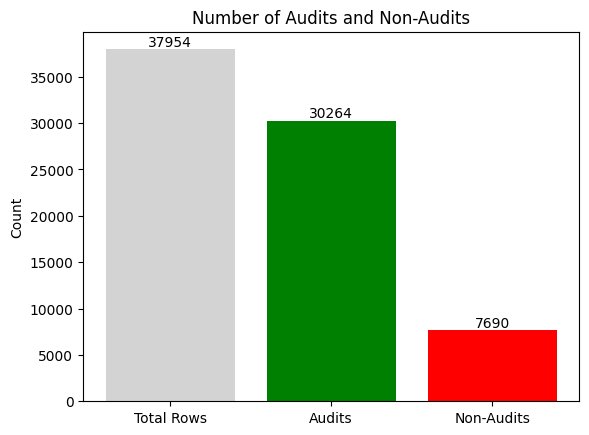

In [ ]:
# Showing visualization of raw data
audit_count = wc_data_df['HasAudit'].sum()
non_audit_count = len(wc_data_df) - audit_count
total_count = len(wc_data_df)

total_bar = plt.bar('Total Rows', total_count, color='lightgray', label='Total Rows')
audit_bar = plt.bar('Audits', audit_count, color='green', label='Rows with Audits')
non_audit_bar = plt.bar('Non-Audits', non_audit_count, color='red', label='Rows with Non-Audits')

plt.title('Number of Audits and Non-Audits')
plt.ylabel('Count')

def show_exact_number(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

show_exact_number(total_bar)
show_exact_number(audit_bar)
show_exact_number(non_audit_bar)

plt.show()

# Raw Data: Logisitics Classification, Random Forest, PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 'wc_data_df' contains the appropriate one hot encoded columns --> applied to all categorical variables
#categorical columns are replaced with binary cols
encoded_wc_data_df = pd.get_dummies(wc_data_df, columns=["ProductMasterLineName", "ProductLineName", "StateCode", "SIC_2_Code", "CarrierMasterParentName", "TierName"])


In [ ]:
encoded_wc_data_df.head(5)

,CompanySalesAmt_USD,EmployeesTotalCount,BilledPremium,Limits,Exposure,HasAudit,ProductMasterLineName_C - WORKERS COMPENSATION-ALL OTHER,ProductMasterLineName_C - WORKERS COMPENSATION-EXCESS SPECIFIC AND/OR AGGREGATE,ProductMasterLineName_C - WORKERS COMPENSATION-STANDARD,ProductLineName_BRK WORKERS COMPENSATION - FOREIGN,...,CarrierMasterParentName_WHITE MOUNTAINS INSURANCE GROUP,CarrierMasterParentName_WILLIS GROUP HOLDINGS LIMITED,CarrierMasterParentName_WSIB INSURANCE AGENCY LLC,CarrierMasterParentName_ZURICH FINANCIAL SERVICES LTD,TierName_REGIONAL,TierName_SPECIALTY,TierName_TIER 1,TierName_TIER 2,TierName_TIER 3,TierName_UNKNOWN
772,58970177.0,245.0,29500.0,3000000.0,34979400.0,1,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
919,292129.0,9.0,468.0,9305000.0,0.0,1,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
930,110000.0,2.0,1325.0,3000000.0,246816.0,1,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1043,610675.0,16.0,7509.0,4105000.0,14136.0,0,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1079,11718848.0,82.0,107643.0,3000000.0,6236780.0,1,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
encoded_wc_data_df['HasAudit'] = encoded_wc_data_df['HasAudit'].apply(lambda x:True if x == 1 else False)

In [ ]:
features = encoded_wc_data_df.drop(columns=['HasAudit'])

In [ ]:
target = encoded_wc_data_df['HasAudit']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42) #random seed ensures reproducibility

In [ ]:
#LOGISTICS WITHOUT PCA

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
# logistic accuracy
log_acc = clf.score(X_test, y_test)

In [ ]:
log_acc

0.8001580819391384

In [ ]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=30, random_state=42, n_estimators=120, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# random forest accuracy
rf_acc = clf.score(X_test, y_test)


# rf_confusion = confusion_matrix(y_test, y_pred)

In [ ]:
rf_acc

0.8537742062969306

In [ ]:
from sklearn.metrics import precision_recall_fscore_support


precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.66943522 0.88852356]
recall: [0.53096179 0.93446402]
fscore: [0.59221161 0.91091493]
support: [1518 6073]


In [ ]:
#PREFORMING THE PCA --> to reduce dimensionality (reduce the num of features whilst keeping the most important properties from wc's data)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)

#Instantiate and Fit PCA
pca = PCA() #includes all the principal components
X_train_pca = pca.fit_transform(X_train_scaled)

In [ ]:

explained_variance_ratios = pca.explained_variance_ratio_


cum_evr = explained_variance_ratios.cumsum()

Text(0.5, 1.0, 'Cumulative Explained Variance Ratio Against the Number of Components')

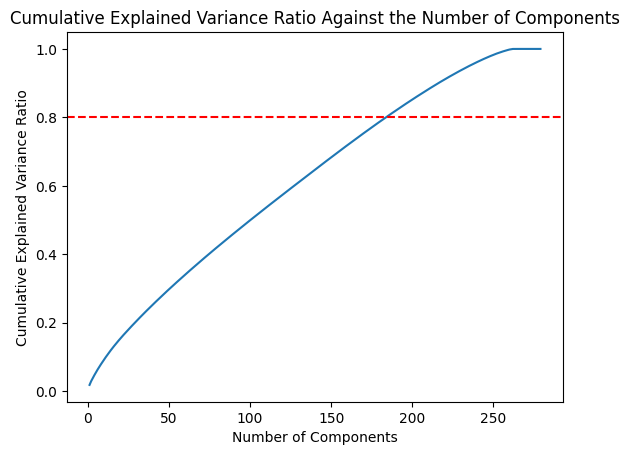

In [ ]:
components = range(1, len(cum_evr)+1) #chart below became slightly more steep
sns.lineplot(x=components, y=cum_evr)
plt.axhline(y = 0.8, color = 'r', linestyle = '--', label ='80% variance threshold')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio Against the Number of Components')

In [ ]:
# get transformed set of principal components on x_test

# 1. Refit and transform on training with parameter n (as deduced from the last step)
pca = PCA(n_components=185)
X_train_pca = pca.fit_transform(X_train_scaled)

# 2. Transform on Testing Set and store it as `X_test_pca`
X_test_pca = pca.transform(ss.transform(X_test))

In [ ]:
#LOGISTICS WITH PCA


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# `log_reg_pca` model with default parameters and fit it on the PCA transformed training set
log_reg_pca = LogisticRegression()
log_reg_pca.fit(X_train_pca, y_train) #fit on training data ONLY EVER

# Use model to predict on the PCA transformed test set
y_pred = log_reg_pca.predict(X_test_pca)

# accuracy
test_accuracy = accuracy_score(y_test, y_pred)

In [ ]:
test_accuracy

0.822553023317086

In [ ]:
from sklearn.metrics import precision_recall_fscore_support


precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

# [nonaudits, audits]

precision: [0.7060241  0.82929208]
recall: [0.19301713 0.97991108]
fscore: [0.30315572 0.89833195]
support: [1518 6073]


What the data means so far:

**Precision**: How many instances predicted as positive (audit conducted) by the model are actually positive. A higher precision indicates fewer false positives. Which means better model.

**Recall:** How many of the actual positive instances (audit conducted) model correctly identifies. A higher recall indicates fewer false negatives. Which means better model.

**Fscore:** Combines precision + recall. Used to determine if a balance needs to be done.

**Support:** The actual number of non-audits vs. audits.


# Oversampling non-aduits using 2 automatic methods

# **Using SMOTE**

In [ ]:
#model does excellent job at predicting audits, but preforms poorly for predicting nonaudits (low recall --> high false -ves) & (low fscore)
#Solution: oversample the nonaudits to get it more balanced as current data has significantly less nonaudits than audits

#PCA with oversampling below

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42) #random seed ensures reproducibility

In [ ]:
#OVERSAMPING DATA
#import from here, read about it further here: https://imbalanced-learn.org/stable/over_sampling.html
#https://stackoverflow.com/questions/15065833/imbalance-in-scikit-learn

# A more advanced oversampling technique is SMOTE, short for Synthetic Minority Oversampling Technique.
# SMOTE generates synthetic samples for the minority class instead of just duplicating them. This creates more variety in the training data.

from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)


In [ ]:
from sklearn.linear_model import LogisticRegression
#Logistic Regression without PCA after oversampling nonaduits randomly (see attached link in above cell)
clf = LogisticRegression(random_state=42).fit(X_resampled, y_resampled)
y_pred_resample = clf.predict(X_test)
# logistic accuracy
log_acc_resample = clf.score(X_test, y_test)

In [ ]:
log_acc_resample

0.7938348043736003

In [ ]:
# RANDOM FOREST with oversampled data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=30, random_state=42, n_estimators=120, class_weight='balanced', criterion="entropy")
clf.fit(X_resampled, y_resampled)
y_pred_resample = clf.predict(X_test)

# random forest accuracy
rf_acc_resample = clf.score(X_test, y_test)
rf_acc_resample

0.8619417731524174

In [ ]:
from sklearn.metrics import precision_recall_fscore_support


precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_resample)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.73490276 0.87904445]
recall: [0.47299078 0.95735221]
fscore: [0.5755511  0.91652873]
support: [1518 6073]


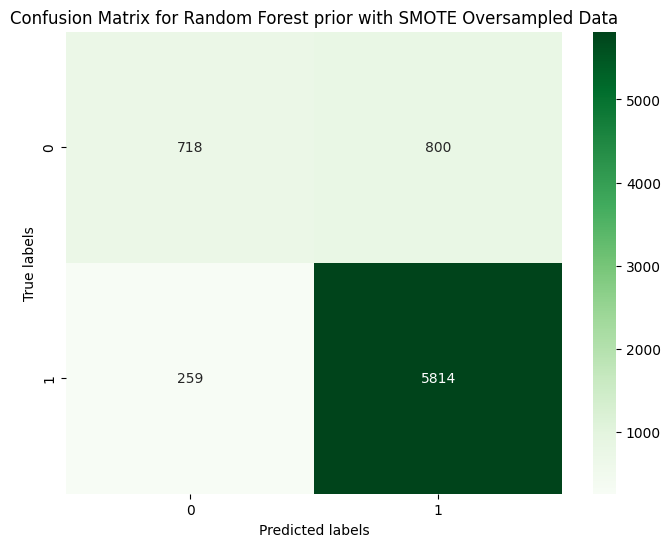

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_resample)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest prior with SMOTE Oversampled Data')
plt.show()

In [ ]:
# Get feature importances --> from the random forest model
feature_importances = clf.feature_importances_

# Get names of the features
feature_names = features.columns

# Create a df to display feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort df by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


print(feature_importance_df)

                                               Feature  Importance
2                                        BilledPremium    0.127404
4                                             Exposure    0.109041
1                                  EmployeesTotalCount    0.056088
0                                  CompanySalesAmt_USD    0.055725
277                                    TierName_TIER 3    0.039292
..                                                 ...         ...
98                                       SIC_2_Code_40    0.000000
72                                       SIC_2_Code_12    0.000000
227    CarrierMasterParentName_PREFERRED CONCEPTS, INC    0.000000
230  CarrierMasterParentName_PROGRAM INSURANCE MANA...    0.000000
247         CarrierMasterParentName_THE FAIRWAY AGENCY    0.000000

[279 rows x 2 columns]


<ipython-input-60-4286ddee3939>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


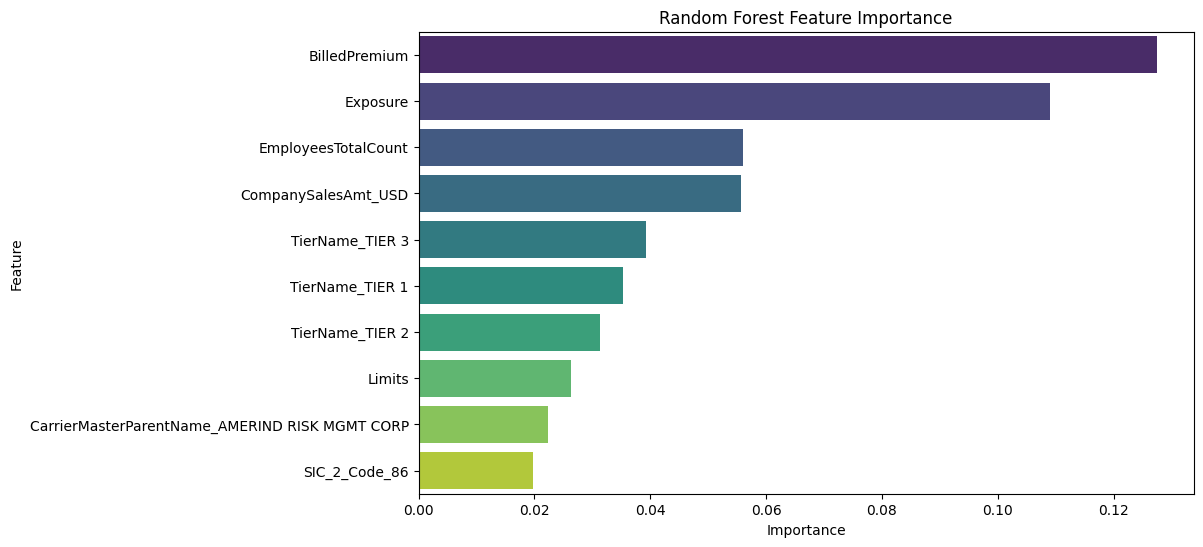

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Graph top 10 columns
importance_df = feature_importance_df.head(10)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_resampled)

#Instantiate and Fit PCA
pca = PCA() #includes all the principal components
X_train_pca = pca.fit_transform(X_train_scaled)

explained_variance_ratios = pca.explained_variance_ratio_

cum_evr = explained_variance_ratios.cumsum()

Text(0.5, 1.0, 'Cumulative Explained Variance Ratio Against the Number of Components')

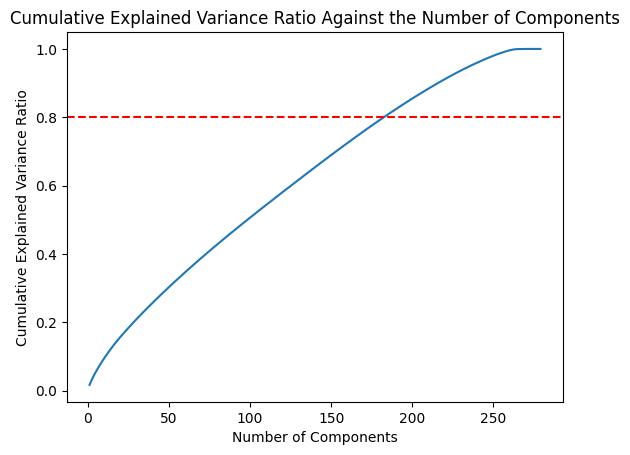

In [ ]:
components = range(1, len(cum_evr)+1)
sns.lineplot(x=components, y=cum_evr)
plt.axhline(y = 0.8, color = 'r', linestyle = '--', label ='80% variance threshold')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio Against the Number of Components')

In [ ]:
# 1. Refit and transform on training with parameter n (as from the last step)
pca = PCA(n_components=185)
X_train_pca = pca.fit_transform(X_train_scaled)

# 2. Transform on Testing Set
X_test_pca = pca.transform(ss.transform(X_test))

In [ ]:
#LOGISTICS WITH PCA with oversampled data

# as before, create a `log_reg_pca` model with default parameters and fit it on the PCA transformed training set
log_reg_pca = LogisticRegression()
log_reg_pca.fit(X_train_pca, y_resampled) #fit on training data ONLY EVER

# Use the model to predict on the PCA transformed test set
y_pred = log_reg_pca.predict(X_test_pca)

# accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.6966144118034514

In [ ]:
# Observing metrics after oversampling of nonaudits
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

# [nonaudits, audits]

precision: [0.34102876 0.8680203 ]
recall: [0.55467721 0.73209287]
fscore: [0.42237271 0.79428316]
support: [1518 6073]


# **Scikit** oversampling of the non-audit data to obtain higher recall

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42) #random seed ensures reproducibility

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#Logistic Regression without PCA after oversampling nonaduits randomly (see attached link in above cell)
clf = LogisticRegression(random_state=42).fit(X_resampled, y_resampled)
y_pred_resample = clf.predict(X_test)
# logistic accuracy
log_acc_resample = clf.score(X_test, y_test)
log_acc_resample

0.7885654064023185

In [ ]:
from sklearn.metrics import precision_recall_fscore_support


precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_resample)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.38582677 0.80984743]
recall: [0.09683794 0.9614688 ]
fscore: [0.15481833 0.87916886]
support: [1518 6073]


In [ ]:
# RANDOM FOREST with oversampled data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=30, random_state=42, n_estimators=120, class_weight='balanced', criterion="entropy")
clf.fit(X_resampled, y_resampled)
y_pred_resample = clf.predict(X_test)

# random forest accuracy
rf_acc_resample = clf.score(X_test, y_test)
rf_acc_resample

0.8404689764194441

In [ ]:
from sklearn.metrics import precision_recall_fscore_support


precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_resample)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.60492139 0.89670366]
recall: [0.58300395 0.90482463]
fscore: [0.59376048 0.90074584]
support: [1518 6073]


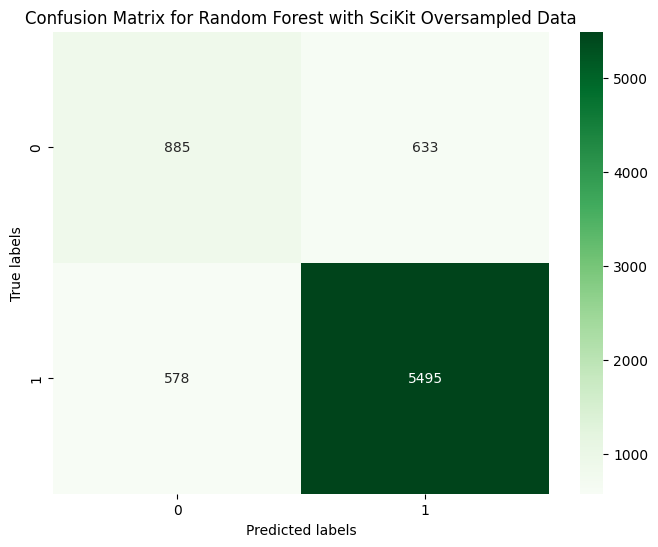

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_resample)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest with SciKit Oversampled Data')
plt.show()

In [ ]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_resampled)

#Instantiate and Fit PCA
pca = PCA() #includes all the principal components
X_train_pca = pca.fit_transform(X_train_scaled)

explained_variance_ratios = pca.explained_variance_ratio_

cum_evr = explained_variance_ratios.cumsum()

Text(0.5, 1.0, 'Cumulative Explained Variance Ratio Against the Number of Components')

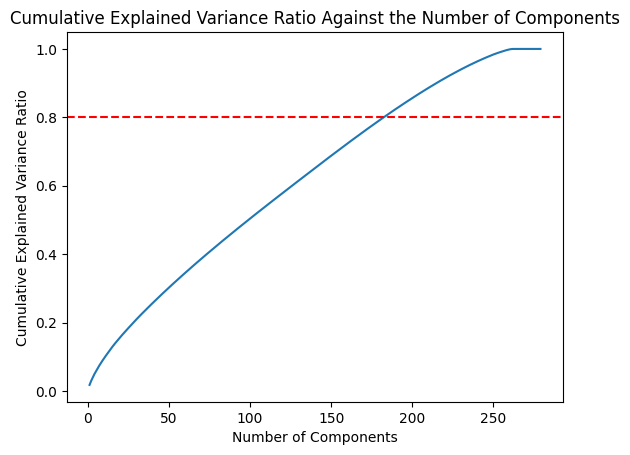

In [ ]:
components = range(1, len(cum_evr)+1)
sns.lineplot(x=components, y=cum_evr)
plt.axhline(y = 0.8, color = 'r', linestyle = '--', label ='80% variance threshold')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio Against the Number of Components')

In [ ]:
# 1. Refit and transform on training with parameter n (obtained from the last step)
pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train_scaled)

# 2. Transform on Testing Set
X_test_pca = pca.transform(ss.transform(X_test))

In [ ]:
#LOGISTICS WITH PCA with oversampled data

log_reg_pca = LogisticRegression()
log_reg_pca.fit(X_train_pca, y_resampled) #fit on training data ONLY EVER

# Use the model to predict on the PCA transformed test set
y_pred = log_reg_pca.predict(X_test_pca)

# accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.6729021209326834

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Observing metrics after oversampling of nonaudits
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

# [nonaudits, audits]

precision: [0.32662594 0.87333611]
recall: [0.59881423 0.69142104]
fscore: [0.4226924  0.77180406]
support: [1518 6073]


#Neural Network

In [ ]:
import sklearn.neural_network as nn

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42) #random seed ensures reproducibility

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42) #random seed ensures reproducibility

In [ ]:
#OVERSAMPING DATA
#double check if this import can be used: https://imbalanced-learn.org/stable/over_sampling.html
#https://stackoverflow.com/questions/15065833/imbalance-in-scikit-learn

# A more advanced oversampling technique is SMOTE, short for Synthetic Minority Oversampling Technique.
# SMOTE generates synthetic samples for the minority class instead of just duplicating them. This creates more variety in the training data.

from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_resampled)
X_test = sc.transform(X_test)

pca = PCA()
pca.fit_transform(X_resampled)

array([[-7.82712593e+08,  3.55556631e+08, -1.11722682e+06, ...,
        -6.35959336e-08, -4.99868430e-08, -6.89273020e-16],
       [-8.52581650e+08,  1.27619420e+09, -6.05582152e+06, ...,
        -5.08569173e-08, -8.78300274e-08, -1.36891586e-15],
       [-8.10182793e+08, -2.21274156e+07,  8.94878163e+04, ...,
         8.70972647e-07, -3.08881968e-07,  7.01382668e-16],
       ...,
       [-8.05018572e+08, -1.45044249e+07,  6.50418629e+04, ...,
         1.63496924e-08,  5.27768061e-08,  3.72814967e-16],
       [-8.55463093e+08, -2.91905471e+07,  1.12951226e+05, ...,
         1.70867998e-08,  1.10521733e-08, -8.24212235e-17],
       [-8.55336480e+08, -2.93446951e+07, -1.38656668e+06, ...,
        -1.20845649e-08,  2.61788983e-08,  1.64037321e-16]])

In [ ]:
import sklearn.metrics as sm
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
#solver is theptimization algorithm
#default excepy logistic
#set the model
mlpc = nn.MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', solver='adam', max_iter=200, random_state=42)

# train the model
mlpc.fit(X_resampled, y_resampled)

#predict on the test set
y_pred = mlpc.predict(X_test)

# model performance
mlpc_accuracy = sm.accuracy_score(y_test, y_pred)
mlpc_report = sm.classification_report(y_test, y_pred)

print("Accuracy:", mlpc_accuracy),"\n"
print("Classification Report:\n", mlpc_report)

Accuracy: 0.2020814121986563
Classification Report:
               precision    recall  f1-score   support

       False       0.20      1.00      0.33      1518
        True       0.86      0.00      0.01      6073

    accuracy                           0.20      7591
   macro avg       0.53      0.50      0.17      7591
weighted avg       0.73      0.20      0.07      7591



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
#solver is theptimization algorithm
#default excepy relu
#set the model
mlpc = nn.MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200, random_state=42)

# train the model
mlpc.fit(X_resampled, y_resampled)

#predict on the test set
y_pred = mlpc.predict(X_test)

# model performance
mlpc_accuracy = sm.accuracy_score(y_test, y_pred)
mlpc_report = sm.classification_report(y_test, y_pred)

print("Accuracy:", mlpc_accuracy),"\n"
print("Classification Report:\n", mlpc_report)

Accuracy: 0.7142668950072454
Classification Report:
               precision    recall  f1-score   support

       False       0.32      0.40      0.36      1518
        True       0.84      0.79      0.82      6073

    accuracy                           0.71      7591
   macro avg       0.58      0.59      0.59      7591
weighted avg       0.74      0.71      0.72      7591



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
